In [343]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.graph_objs as go
%matplotlib inline

In [344]:
# Import et aperçu des datasets
df_2024_Table = pd.read_excel("/Users/Thibault/Desktop/WORKFLOW PYTHON/Git-Analyse_du_bien_etre/DataForTable2.1.xls")
df_continents = pd.read_csv("/Users/Thibault/Desktop/WORKFLOW PYTHON/Git-Analyse_du_bien_etre/continents2.csv")

display(df_2024_Table.head())
display(df_continents.head())

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


________________________________

## Nettoyage des données

In [345]:
# Correspondance des noms de pays
df_2024_Table['Country name'] = df_2024_Table['Country name'].replace({'Türkiye':'Turkey',
                                                                       'Taiwan Province of China':'Taiwan',
                                                                       'Hong Kong S.A.R. of China':'Hong Kong'
                                                                       })

df_continents['name'] = df_continents['name'].replace({'Bosnia And Herzegovina':'Bosnia and Herzegovina',
                                                       'Congo (Democratic Republic Of The)':'Congo (Brazzaville)',
                                                       'Congo':'Congo (Kinshasa)',
                                                       "Côte D'Ivoire":'Ivory Coast',
                                                       'Czech Republic':'Czechia',
                                                       'Macedonia':'North Macedonia',
                                                       'Palestine, State of':'State of Palestine'
                                                       })

# Merge des 2 datasets
df_2024 = pd.merge(df_2024_Table, df_continents[['name', 'region','sub-region']], left_on = "Country name", right_on = "name", how = 'left')

# Drop colonne "name"
df_2024.drop(columns='name', inplace=True)

# Ordre et casse des colonnes
df_2024 = df_2024[['Country name', 'region', 'sub-region'] + [col for col in df_2024.columns if col not in ['Country name', 'region', 'sub-region']]]

df_2024 = df_2024.rename(columns={'region': 'Region', 'sub-region': 'Sub region', 'year': 'Year'})

# Ajout données Kosovo
df_2024.loc[df_2024['Country name'] == 'Kosovo', ['Region', 'Sub region']] = ['Europe', 'Southern Europe']

# Conservation des 10 dernières années 
df_2024 = df_2024.drop(df_2024[df_2024.Year < 2014].index)

## Modélisation

### Préprocessing

##### Import des packages

In [346]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
import statsmodels.api as sm

##### Préparation des données

In [347]:
# Drop des colonnes  Country name, Region et Sub region
df = df_2024.drop(['Year', 'Country name'], axis = 1)

In [348]:
# Séparation en deux dataframe

feats = df.drop('Life Ladder', axis=1)
target = df['Life Ladder']


# Séparation en données d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state = 42)

#	One-Hot Encoding sur données entrainement

OHE = OneHotEncoder(drop='first', sparse_output=False)  
X_train_encoded = OHE.fit_transform(X_train[['Region', 'Sub region']])
X_test_encoded = OHE.transform(X_test[['Region', 'Sub region']])

# convertir encodages en df
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=OHE.get_feature_names_out(['Region', 'Sub region']))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=OHE.get_feature_names_out(['Region', 'Sub region']))

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Concaténer les df encodés 
X_train_full = pd.concat([X_train.drop(['Region', 'Sub region'], axis=1), X_train_encoded_df], axis=1)
X_test_full = pd.concat([X_test.drop(['Region', 'Sub region'], axis=1), X_test_encoded_df], axis=1)

# Gestion valeurs manquantes

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_full_imputed = imputer.fit_transform(X_train_full)
X_test_full_imputed = imputer.transform(X_test_full)

all_columns = X_train_full.columns


X_train = pd.DataFrame(X_train_full_imputed, columns=all_columns)
X_test = pd.DataFrame(X_test_full_imputed, columns=all_columns)

print(X_train.head())
print(X_test.head())


   Log GDP per capita  Social support  Healthy life expectancy at birth  \
0            9.380879        0.816925                         63.049999   
1            9.576818        0.870970                         68.824997   
2           10.067001        0.933471                         67.500000   
3            8.883399        0.707336                         59.900002   
4           10.057425        0.863067                         65.720001   

   Freedom to make life choices  Generosity  Perceptions of corruption  \
0                      0.884856    0.540485                   0.845080   
1                      0.850766   -0.154003                   0.854821   
2                      0.902679   -0.107435                   0.599400   
3                      0.891001    0.068111                   0.591617   
4                      0.808384    0.235280                   0.844815   

   Positive affect  Negative affect  Region_Americas  Region_Asia  ...  \
0         0.798547         0.2

In [360]:
df.isna().sum()
df.isna().any(axis=1).sum()
display(X_train.shape)
display(X_test.shape)


(1099, 25)

(275, 25)

##### Random Forest

In [352]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

0.984488048873326
0.8881033184868163


RANDOM FOREST
Mean Absolute Error: 0.27 : erreur moyenne absolue en unités réelles de la variable cible
Mean Squared Error: 0.13 :  moyenne des carrés des erreurs entre les valeurs prédites et les valeurs réelles.
R² Score: 0.89 : indique à quel point le modèle explique la variance des données 
Mean Absolute Percentage Error (MAPE): 5.27%: affiche l'erreur en % relatif aux valeurs réelles 


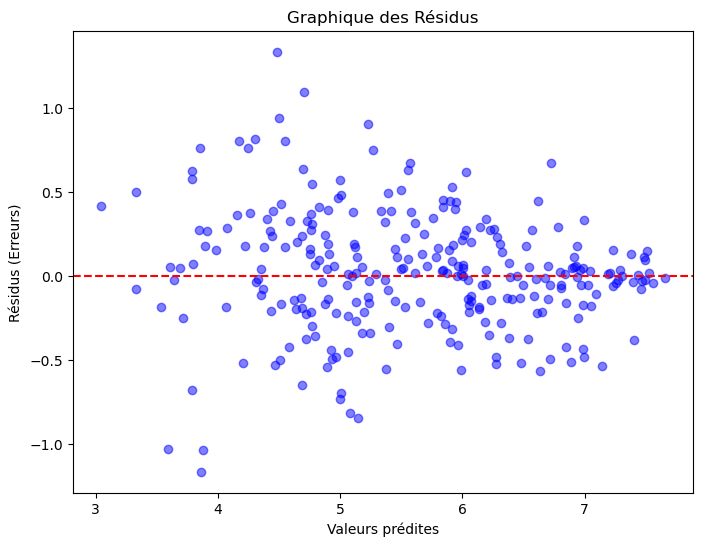

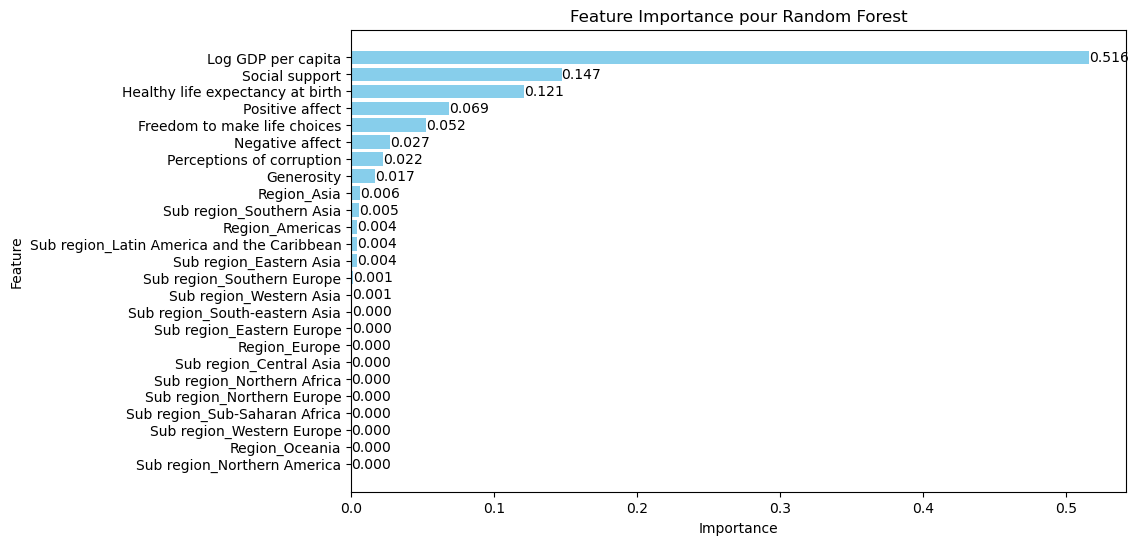

In [365]:
# Prédictions
y_pred = rf.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
dw_stat = sm.stats.stattools.durbin_watson(y_test - y_pred)

print("RANDOM FOREST")
print(f"Mean Absolute Error: {mae:.2f}", ": erreur moyenne absolue en unités réelles de la variable cible")
print(f"Mean Squared Error: {mse:.2f}", ":  moyenne des carrés des erreurs entre les valeurs prédites et les valeurs réelles.")
print(f"R² Score: {r2:.2f}", ": indique à quel point le modèle explique la variance des données ")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}" ": affiche l'erreur en % relatif aux valeurs réelles ")


# Graphique des résidus
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus (Erreurs)')
plt.title('Graphique des Résidus')
plt.show()

#Feature importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
for index, value in enumerate(feature_importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance pour Random Forest')
plt.gca().invert_yaxis()  # Inverser l'axe Y pour avoir les caractéristiques les plus importantes en haut
plt.show()




##### XGBoost 

In [354]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [355]:
import xgboost as xgb



In [356]:
dtrain = xgb.DMatrix(X_train_df, label=y_train, feature_names=list(X_train.columns))
dtest = xgb.DMatrix(X_test_df, label=y_test, feature_names=list(X_test.columns))

In [357]:
params = {
    'objective': 'reg:squarederror',  
    'max_depth': 7,                  
    'eta': 0.1,                       
    'subsample': 0.8,                 
    'colsample_bytree': 0.8,          
    'seed': 42      
}
num_boost_round = 150  
model = xgb.train(params, dtrain, num_boost_round)

y_pred = model.predict(dtest)







XGBOOST
Mean Absolute Error: 0.25 : erreur moyenne absolue en unités réelles de la variable cible
Mean Squared Error: 0.11 : moyenne des carrés des erreurs entre les valeurs prédites et les valeurs réelles.
R² Score: 0.90 : indique à quel point le modèle explique la variance des données 
Mean Absolute Percentage Error (MAPE): 4.93%: affiche l'erreur en % relatif aux valeurs réelles 


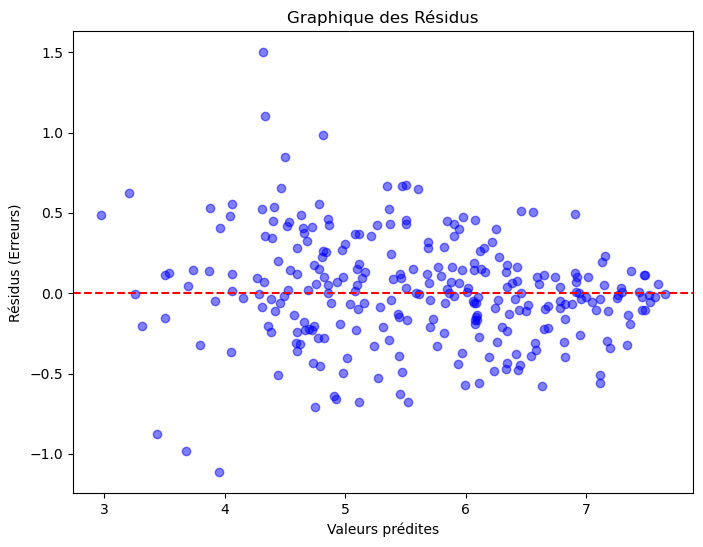

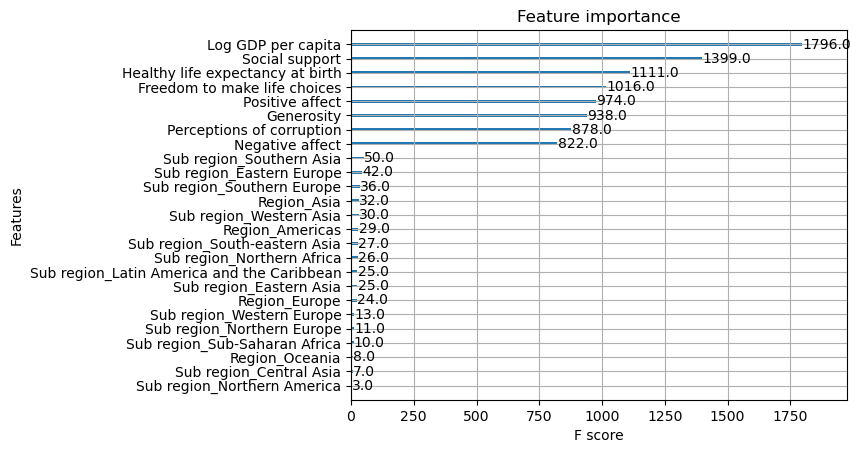

In [368]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(0.14)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
dw_stat = sm.stats.stattools.durbin_watson(y_test - y_pred) 

print("XGBOOST")
print(f"Mean Absolute Error: {mae:.2f}", ": erreur moyenne absolue en unités réelles de la variable cible")
print(f"Mean Squared Error: {mse:.2f}", ": moyenne des carrés des erreurs entre les valeurs prédites et les valeurs réelles.")
print(f"R² Score: {r2:.2f}", ": indique à quel point le modèle explique la variance des données ")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}" ": affiche l'erreur en % relatif aux valeurs réelles ")

# Graphique des résidus
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus (Erreurs)')
plt.title('Graphique des Résidus')
plt.show()

#Feature importance
y_pred = model.predict(dtest)
xgb.plot_importance(model)
plt.show()




### XGBoost - Données normalisées

XGBOOST - DONNEES NORMALISEES
Mean Absolute Error: 0.25 : erreur moyenne absolue en unités réelles de la variable cible
Mean Squared Error: 0.11 : moyenne des carrés des erreurs entre les valeurs prédites et les valeurs réelles.
R² Score: 0.90 : indique à quel point le modèle explique la variance des données 
Mean Absolute Percentage Error (MAPE): 4.93%: affiche l'erreur en % relatif aux valeurs réelles 


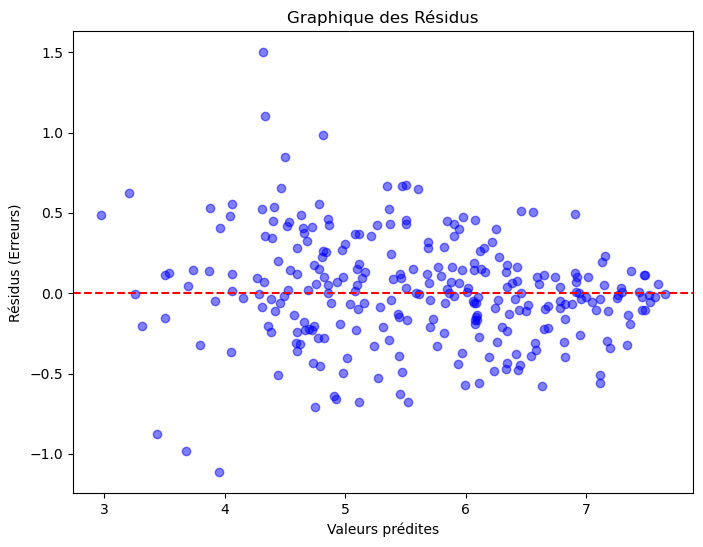

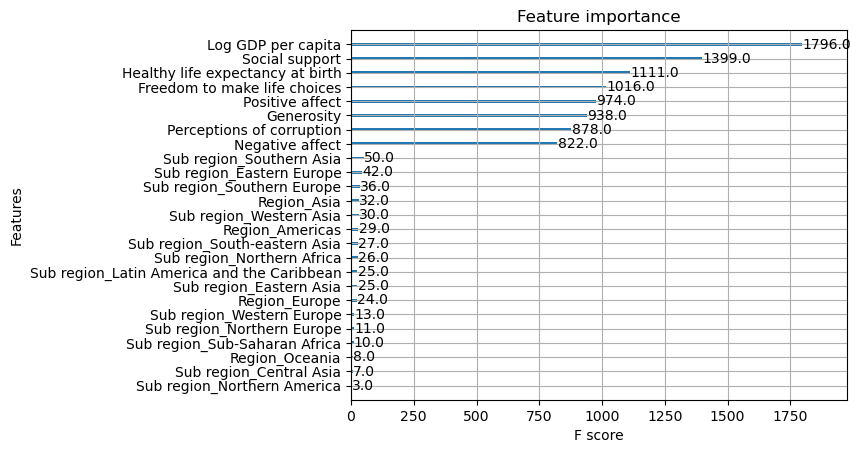

In [367]:
#Test avec données normalisées via différents outils de scaling - pas d'amélioration 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

#scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=list(X_train.columns))
dtest2 = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=list(X_test.columns))

params = {
    'objective': 'reg:squarederror',  
    'max_depth': 7,                  
    'eta': 0.1,                       
    'subsample': 0.8,                 
    'colsample_bytree': 0.8,          
    'seed': 42      
}
num_boost_round = 150  
model = xgb.train(params, dtrain, num_boost_round)

y_pred = model.predict(dtest2)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(0.14)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
dw_stat = sm.stats.stattools.durbin_watson(y_test - y_pred) 

print("XGBOOST - DONNEES NORMALISEES")
print(f"Mean Absolute Error: {mae:.2f}", ": erreur moyenne absolue en unités réelles de la variable cible")
print(f"Mean Squared Error: {mse:.2f}", ": moyenne des carrés des erreurs entre les valeurs prédites et les valeurs réelles.")
print(f"R² Score: {r2:.2f}", ": indique à quel point le modèle explique la variance des données ")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}" ": affiche l'erreur en % relatif aux valeurs réelles ")

# Graphique des résidus
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus (Erreurs)')
plt.title('Graphique des Résidus')
plt.show()



#Feature importance
y_pred = model.predict(dtest2)
xgb.plot_importance(model)
plt.show()
